In [1]:
import open3d as o3d
from o3d_tools.visualize import PointCloudProject
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.data import Dataset, DataLoader
import torch_cluster
import torch.nn.functional as F
from torch_geometric.nn import PointTransformerConv, global_max_pool, knn_graph
import torch.optim as optim

from tqdm import tqdm 
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [144]:
import warnings

warnings.simplefilter("ignore", UserWarning)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
project1 = PointCloudProject(project='Project1') ; project2 = PointCloudProject(project='Project2')
project3 = PointCloudProject(project='Project3') ; project4 = PointCloudProject(project='Project4')

In [4]:
def read_and_preprocess_data():

    objs1 = project1.objects_df

    print(f"Types of objects in Project 1: {list(objs1.keys())}")
    pipes1 = objs1["Pipe"]
    scbs1 = objs1["Structural_ColumnBeam"]
    sibs1 = objs1["Structural_IBeam"]
    hvducts = objs1["HVAC_Duct"]

    objs2 = project2.objects_df

    print(f"Types of objects in Project 2: {list(objs2.keys())}")
    pipes2 = objs2["Pipe"]
    scbs2 = objs2["Structural_ColumnBeam"]
    sibs2 = objs2["Structural_IBeam"]

    objs3 = project3.objects_df

    print(f"Types of objects in Project 3: {list(objs3.keys())}")
    scbs3 = objs3["Structural_ColumnBeam"]

    objs4 = project4.objects_df

    print(f"Types of objects in Project 4: {list(objs4.keys())}")
    sibs4 = objs4["Structural_IBeam"]


    boxes1 = pd.concat([scbs1, hvducts, pipes1, sibs1])
    boxes2 = pd.concat([scbs2, pipes2, sibs2])
    boxes3 = scbs3
    boxes4 = sibs4

    boxes = [boxes1, boxes2, boxes3, boxes4]

    for i in range(len(boxes)):
        boxes[i].rename(columns={" Label": "label", " BB.Min.X " : "min_x", " BB.Min.Y " : "min_y", " BB.Min.Z " : "min_z",
                             " BB.Max.X " : "max_x", " BB.Max.Y " : "max_y", " BB.Max.Z" : "max_z"}, inplace=True)

    box_data = pd.concat(boxes)

    ids_to_points = {}

    projects = [project1, project2, project3, project4]

    for proj_id, box in enumerate(boxes):

        for i, ID in enumerate(box["ID"]):

            proj = projects[proj_id]

            # .pcd.crop() method expects this bounding box object, create it from the raw min max values
            bb = o3d.geometry.AxisAlignedBoundingBox((box[["min_x", "min_y", "min_z"]].iloc[i]).to_numpy(), 
                                        (box[["max_x", "max_y", "max_z"]].iloc[i]).to_numpy())

            points_of_id = proj.pcd.crop(bb)

            # convert the pointcloud object into a numpy array
            # join coordinates and color data into a single 6d nparray for each point

            points_coords = np.asarray(points_of_id.points)

            tmp = np.asarray(points_of_id.colors)[:,0]

            points_colors = (np.asarray(points_of_id.colors)[:,0]).reshape(-1,1)

            points_arr = np.concatenate((points_coords, points_colors), axis = 1)

            ids_to_points[ID] = points_arr

    def sample_point_cloud(points, num_points):

        if points.shape[0] > num_points:

            # Downsample if the point cloud has more points than needed
            idx = np.random.choice(points.shape[0], num_points, replace=False)
            return points[idx, :]

        elif points.shape[0] < num_points:
            # Upsample by repeating random points if the point cloud has fewer points than needed
            idx = np.random.choice(points.shape[0], num_points - points.shape[0], replace=True)
            return np.concatenate([points, points[idx, :]], axis=0)

        else:
            # Return the point cloud as is if it already has the correct number of points
            return points

    fixed_num_points = 2048  # The fixed number of points for all point clouds

    point_clouds_resampled = {}

    for obj_id in ids_to_points.keys():

        point_cloud = ids_to_points[obj_id]
        resampled_points = sample_point_cloud(point_cloud, fixed_num_points)
        point_clouds_resampled[obj_id] = resampled_points
        
    def extract_bounding_box_features(min_x, max_x, min_y, max_y, min_z, max_z):
    
        centroid = [(min_x + max_x) / 2, (min_y + max_y) / 2, (min_z + max_z) / 2]
        size = [max_x - min_x, max_y - min_y, max_z - min_z]
        volume = size[0] * size[1] * size[2]
        
        return np.array(centroid + size + [volume])
    
    data = []
    for i in range(box_data.shape[0]):

        box = box_data.iloc[i]
        features = extract_bounding_box_features(box["min_x"], box["max_x"], box["min_y"],
                                                 box["max_y"], box["min_z"], box["max_z"])

        data.append(features)

    feature_df = pd.DataFrame(data, columns=["cx", "cy", "cz", "sx", "sy", "sz", "vol"])
    
    box_data = box_data.reset_index(drop=True)
    
    new_box_data = pd.concat([box_data, feature_df], axis=1)
    
    return point_clouds_resampled, new_box_data

points_dict, box_data = read_and_preprocess_data()

print("Initial preprocessing done")

y = box_data["label"]
X = box_data[["ID", "min_x", "min_y", "min_z", "max_x", "max_y", "max_z", "cx", "cy", "cz", "sx", "sy", "sz", "vol"]]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train val test split done")

label_mapping = {
    'Structural_ColumnBeam': 0,
    'HVAC_Duct': 1,
    'Pipe': 2,
    'Structural_IBeam': 3
}

labels_enc = []
for row in box_data["label"]:

    labels_enc.append(label_mapping[row])

box_data["label_enc"] = labels_enc

print("Label encoding done")

class CustomData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'bbox_features':
            return None  # Indicates that bbox_features is a graph-level attribute
        else:
            return super(CustomData, self).__cat_dim__(key, value, *args, **kwargs)

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'bbox_features':
            return 0  # No increment needed for graph-level attributes
        else:
            return super(CustomData, self).__inc__(key, value, *args, **kwargs)

def create_point_cloud_data(points, bounding_box_features, labels):

    x = torch.tensor(points[:,3:], dtype=torch.float)  # Pointcolors
    pos = torch.tensor(points[:, :3], dtype=torch.float) # Point coords

    bounding_box_features = torch.tensor(bounding_box_features, dtype=torch.float)

    # Create the Data object
    data = CustomData(x=x, pos=pos, bbox_features=bounding_box_features, y=torch.tensor(labels, dtype=torch.long))

    return data

data_dict = {}
features_list = ["cx", "cy", "cz", "sx", "sy", "sz", "vol"]

for obj_id in points_dict.keys():

    curr_label = ((box_data[box_data["ID"] == obj_id].iloc[:,15]).to_numpy()).reshape(1)
    curr_features = ((box_data[box_data["ID"] == obj_id].loc[:,features_list]).to_numpy()).reshape(7)
    
    data_dict[obj_id] = create_point_cloud_data(points_dict[obj_id], curr_features, curr_label)

train_data_objs = {}
val_data_objs = {}
test_data_objs = {}

for key in X_train["ID"]:

    train_data_objs[key] = data_dict[key]

for key in X_val["ID"]:

    val_data_objs[key] = data_dict[key]

for key in X_test["ID"]:

    test_data_objs[key] = data_dict[key]


train_data_arr = []
val_data_arr = []
test_data_arr = []

for key in train_data_objs.keys():

    train_data_arr.append(train_data_objs[key])

for key in val_data_objs.keys():

    val_data_arr.append(val_data_objs[key])

for key in test_data_objs.keys():

    test_data_arr.append(test_data_objs[key])

Types of objects in Project 1: ['Structural_ColumnBeam', 'HVAC_Duct', 'Pipe', 'Structural_IBeam']
Types of objects in Project 2: ['Structural_ColumnBeam', 'Pipe', 'Structural_IBeam']
Types of objects in Project 3: ['Structural_ColumnBeam']
Types of objects in Project 4: ['Structural_IBeam']
Initial preprocessing done
Train val test split done
Label encoding done


In [63]:
class PointTransformerModel(torch.nn.Module):

    #------------Model architecture--------------
    def __init__(self, num_classes=4, bbox_input_size=7):
        
        super(PointTransformerModel, self).__init__()
        torch.manual_seed(65536)
        #--------------Point Transformer layers----------------
        self.conv1 = PointTransformerConv(in_channels=1, out_channels=10)
        self.conv2 = PointTransformerConv(in_channels=10, out_channels=20)
        self.conv3 = PointTransformerConv(in_channels=20, out_channels=30)

        #-------Fully connected layers for the bounding box features-------
        self.fc_bbox = torch.nn.Sequential(
            torch.nn.Linear(bbox_input_size, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20)
        )

        #-------Final layers that take in the concatenated point cloud features and bounding box features------
        #------Note: don't apply softmax at the end because when we use the cross entropy loss function that does 
        #------softmax in the code, so leave raw logits as output instead
        self.fc_final = torch.nn.Sequential(
            torch.nn.Linear(50, 10),
            torch.nn.ReLU(),
            #torch.nn.Dropout(0.2),
            torch.nn.Linear(10, num_classes)
        )

    def forward(self, data):
        
        x, pos, batch = data.x, data.pos, data.batch
        edge_index = knn_graph(pos, k=5, batch=batch, loop=False)
        
        x = F.relu(self.conv1(x, pos, edge_index))
        x = F.relu(self.conv2(x, pos, edge_index))
        x = F.relu(self.conv3(x, pos, edge_index))

        x = global_max_pool(x, batch)

        bbox_features = data.bbox_features
        if bbox_features.dim() == 1:
            bbox_features = bbox_features.unsqueeze(0)
            
        bbox_out = self.fc_bbox(bbox_features)

        #-------Concatenate learned point cloud features and bounding box features-------- 
        x = torch.cat([x, bbox_out], dim=1)
        
        x = self.fc_final(x)
        
        return x

    def pred_probs(self, data):

        data.to(device)
        logits = self.forward(data)
        probs = F.softmax(logits)
        
        return probs

    def pred(self, data):

        data.to(device)
        logits = self.forward(data)
        probs = F.softmax(logits)
        preds = torch.argmax(probs, axis=1)
        
        return preds

    def train_model(self, train_data, val_data, epochs=10, lr=0.001, weight_decay=1e-4):

        #-----------Set optimizer and loss function-----------
        optimizer = Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = CrossEntropyLoss()

        train_loss_history = [] ; val_loss_history = []
        
        for epoch in range(1, epochs + 1):
        
            self.train()  # Set model to training mode
            total_loss = 0 ; correct = 0 ; total = 0
            
            # Batch loop with progress bar
            pbar = tqdm(train_data, desc=f'Epoch {epoch}/{epochs}')
            for data in pbar:
                data = data.to(device)
                optimizer.zero_grad()
        
                # Forward pass
                outputs = self.forward(data)
                labels = data.y.view(-1)
        
                # Compute loss
                loss = criterion(outputs, labels)
                
                total_loss += loss.item() * data.num_graphs  # Accumulate loss
        
                # Backward pass and optimization
                loss.backward()
                optimizer.step()
        
                # Compute training accuracy
                _, predicted = outputs.max(dim=1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                train_acc = correct / total
        
                # Update progress bar
                pbar.set_postfix(loss=loss.item(), acc=train_acc)
    
            avg_loss = total_loss / size_train
            train_loss_history.append(avg_loss)
            print(f'Epoch {epoch}, Training Loss: {avg_loss:.4f}, Training Accuracy: {train_acc:.4f}')
        
            # Validation phase
            self.eval()  # Set model to evaluation mode
            val_correct = 0; val_total = 0; val_loss = 0
        
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    outputs = self.forward(data)
                    labels = data.y.view(-1)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * data.num_graphs
        
                    _, predicted = outputs.max(dim=1)
                    val_total += labels.size(0)
                    val_correct += predicted.eq(labels).sum().item()
        
            val_acc = val_correct / val_total
            val_loss = val_loss / size_val
            val_loss_history.append(val_loss)
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        
        print('Training complete.')
        return train_loss_history, val_loss_history


In [116]:
size_train = len(train_data_arr)
size_val = len(val_data_arr)
size_test = len(test_data_arr)

batch_size = 10
train_loader = DataLoader(train_data_arr, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data_arr, batch_size=batch_size, shuffle=False)

epochs = 30
lr = 0.0001*3
weight_decay = 1e-5

model = PointTransformerModel(num_classes=4, bbox_input_size=7)
model = model.to(device)

In [117]:
train_loss_history, val_loss_history = model.train_model(train_loader, val_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)

Epoch 1/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.37it/s, acc=0.393, loss=1.42]


Epoch 1, Training Loss: 2.1054, Training Accuracy: 0.3926
Validation Loss: 1.5064, Validation Accuracy: 0.4333


Epoch 2/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.92it/s, acc=0.396, loss=1.51]


Epoch 2, Training Loss: 1.3989, Training Accuracy: 0.3963
Validation Loss: 1.2834, Validation Accuracy: 0.3333


Epoch 3/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.39it/s, acc=0.363, loss=1.37]


Epoch 3, Training Loss: 1.2533, Training Accuracy: 0.3630
Validation Loss: 1.2190, Validation Accuracy: 0.3667


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.85it/s, acc=0.4, loss=1.24]


Epoch 4, Training Loss: 1.1773, Training Accuracy: 0.4000
Validation Loss: 1.1803, Validation Accuracy: 0.4000


Epoch 5/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.97it/s, acc=0.448, loss=1.18]


Epoch 5, Training Loss: 1.1076, Training Accuracy: 0.4481
Validation Loss: 1.1149, Validation Accuracy: 0.4444


Epoch 6/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.28it/s, acc=0.522, loss=1.12]


Epoch 6, Training Loss: 1.0377, Training Accuracy: 0.5222
Validation Loss: 1.0753, Validation Accuracy: 0.4889


Epoch 7/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.41it/s, acc=0.593, loss=1.07]


Epoch 7, Training Loss: 0.9908, Training Accuracy: 0.5926
Validation Loss: 1.0424, Validation Accuracy: 0.5111


Epoch 8/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.04it/s, acc=0.641, loss=1.02]


Epoch 8, Training Loss: 0.9544, Training Accuracy: 0.6407
Validation Loss: 1.0185, Validation Accuracy: 0.5444


Epoch 9/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.04it/s, acc=0.659, loss=0.987]


Epoch 9, Training Loss: 0.9216, Training Accuracy: 0.6593
Validation Loss: 0.9882, Validation Accuracy: 0.5667


Epoch 10/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.98it/s, acc=0.667, loss=0.927]


Epoch 10, Training Loss: 0.8915, Training Accuracy: 0.6667
Validation Loss: 0.9701, Validation Accuracy: 0.5333


Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.14it/s, acc=0.678, loss=0.894]


Epoch 11, Training Loss: 0.8621, Training Accuracy: 0.6778
Validation Loss: 0.9460, Validation Accuracy: 0.5333


Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.40it/s, acc=0.681, loss=0.848]


Epoch 12, Training Loss: 0.8367, Training Accuracy: 0.6815
Validation Loss: 0.9273, Validation Accuracy: 0.5222


Epoch 13/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.12it/s, acc=0.7, loss=0.822]


Epoch 13, Training Loss: 0.8104, Training Accuracy: 0.7000
Validation Loss: 0.9090, Validation Accuracy: 0.5556


Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.48it/s, acc=0.704, loss=0.795]


Epoch 14, Training Loss: 0.7874, Training Accuracy: 0.7037
Validation Loss: 0.8878, Validation Accuracy: 0.5778


Epoch 15/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.32it/s, acc=0.704, loss=0.773]


Epoch 15, Training Loss: 0.7636, Training Accuracy: 0.7037
Validation Loss: 0.8708, Validation Accuracy: 0.6111


Epoch 16/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.85it/s, acc=0.7, loss=0.749]


Epoch 16, Training Loss: 0.7442, Training Accuracy: 0.7000
Validation Loss: 0.8523, Validation Accuracy: 0.6111


Epoch 17/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.26it/s, acc=0.7, loss=0.744]


Epoch 17, Training Loss: 0.7241, Training Accuracy: 0.7000
Validation Loss: 0.8322, Validation Accuracy: 0.6111


Epoch 18/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.68it/s, acc=0.7, loss=0.714]


Epoch 18, Training Loss: 0.7059, Training Accuracy: 0.7000
Validation Loss: 0.8158, Validation Accuracy: 0.6222


Epoch 19/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.79it/s, acc=0.7, loss=0.705]


Epoch 19, Training Loss: 0.6882, Training Accuracy: 0.7000
Validation Loss: 0.7987, Validation Accuracy: 0.6222


Epoch 20/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.19it/s, acc=0.707, loss=0.687]


Epoch 20, Training Loss: 0.6717, Training Accuracy: 0.7074
Validation Loss: 0.7829, Validation Accuracy: 0.6222


Epoch 21/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.97it/s, acc=0.707, loss=0.685]


Epoch 21, Training Loss: 0.6556, Training Accuracy: 0.7074
Validation Loss: 0.7669, Validation Accuracy: 0.6333


Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.41it/s, acc=0.704, loss=0.665]


Epoch 22, Training Loss: 0.6387, Training Accuracy: 0.7037
Validation Loss: 0.7525, Validation Accuracy: 0.6444


Epoch 23/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 50.69it/s, acc=0.711, loss=0.653]


Epoch 23, Training Loss: 0.6205, Training Accuracy: 0.7111
Validation Loss: 0.7399, Validation Accuracy: 0.6556


Epoch 24/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.14it/s, acc=0.715, loss=0.642]


Epoch 24, Training Loss: 0.6049, Training Accuracy: 0.7148
Validation Loss: 0.7216, Validation Accuracy: 0.6556


Epoch 25/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.03it/s, acc=0.73, loss=0.634]


Epoch 25, Training Loss: 0.5889, Training Accuracy: 0.7296
Validation Loss: 0.7038, Validation Accuracy: 0.6667


Epoch 26/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.39it/s, acc=0.748, loss=0.631]


Epoch 26, Training Loss: 0.5733, Training Accuracy: 0.7481
Validation Loss: 0.6843, Validation Accuracy: 0.7000


Epoch 27/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.19it/s, acc=0.752, loss=0.623]


Epoch 27, Training Loss: 0.5581, Training Accuracy: 0.7519
Validation Loss: 0.6633, Validation Accuracy: 0.7000


Epoch 28/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.32it/s, acc=0.756, loss=0.617]


Epoch 28, Training Loss: 0.5427, Training Accuracy: 0.7556
Validation Loss: 0.6445, Validation Accuracy: 0.7222


Epoch 29/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.56it/s, acc=0.767, loss=0.613]


Epoch 29, Training Loss: 0.5276, Training Accuracy: 0.7667
Validation Loss: 0.6247, Validation Accuracy: 0.7222


Epoch 30/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 51.35it/s, acc=0.789, loss=0.609]


Epoch 30, Training Loss: 0.5124, Training Accuracy: 0.7889
Validation Loss: 0.6054, Validation Accuracy: 0.7333
Training complete.


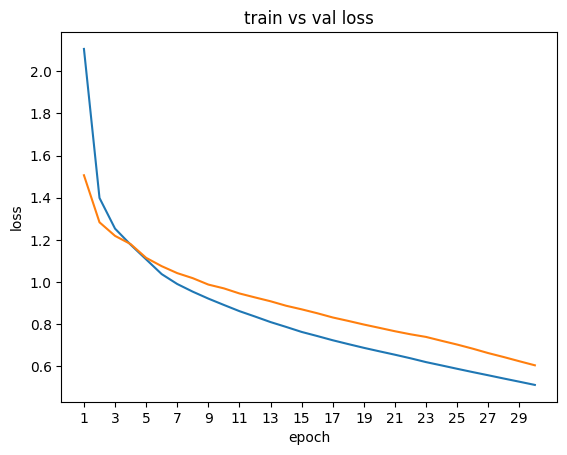

In [118]:
plt.plot(list(range(1,epochs+1)), train_loss_history)
plt.plot(list(range(1,epochs+1)), val_loss_history)
plt.title("train vs val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks([x for x in range(1,epochs+1,2)]);

In [120]:
preds_train = []
for train_batch in train_loader:

    #print(train_batch.y)
    curr_preds = model.pred(train_batch)
    preds_train.append(curr_preds)

#print(preds_train)

preds_train = np.array([[int(x) for x in preds_train[i].cpu()] for i in range(len(preds_train))])
#print(preds_train)
preds_train = preds_train.reshape(270)

/tmp/ipykernel_7423/1853236698.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [140]:
preds_val = []
for val_batch in val_loader:

    #print(train_batch.y)
    curr_preds = model.pred(val_batch)
    preds_val.append(curr_preds)

preds_val = np.array([[int(x) for x in preds_val[i].cpu()] for i in range(len(preds_val))])
#print(preds_train)
preds_val = preds_val.reshape(90)

/home/ubuntu/.local/lib/python3.9/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
/tmp/ipykernel_7423/1853236698.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


In [139]:
y_train_enc = np.array([label_mapping[x] for x in y_train])
y_val_enc = np.array([label_mapping[x] for x in y_val])
y_test_enc = np.array([label_mapping[x] for x in y_test])

In [145]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("-----Training metrics-----")
train_acc = accuracy_score(y_train_enc, preds_train)
print(f"Accuracy: {train_acc}")

train_macro_f1 = f1_score(y_train_enc, preds_train, average='macro')
print(f"Macro F1: {train_macro_f1}")

train_weighted_f1 = f1_score(y_train_enc, preds_train, average='weighted')
print(f"Weighted F1: {train_weighted_f1}")

train_prec = precision_score(y_train_enc, preds_train, average="macro")
print(f"Precision: {train_prec}")


print("-----Validation metrics-----")
val_acc = accuracy_score(y_val_enc, preds_val)
print(f"Accuracy: {val_acc}")

val_macro_f1 = f1_score(y_val_enc, preds_val, average='macro')
print(f"Macro F1: {val_macro_f1}")

val_weighted_f1 = f1_score(y_val_enc, preds_val, average='weighted')
print(f"Weighted F1: {val_weighted_f1}")

val_prec = precision_score(y_val_enc, preds_val, average="macro")
print(f"Precision: {val_prec}")

-----Training metrics-----
Accuracy: 0.825925925925926
Macro F1: 0.6180035650623885
Weighted F1: 0.8168198323100283
Precision: 0.60844087105555
-----Validation metrics-----
Accuracy: 0.7333333333333333
Macro F1: 0.5458378970427163
Weighted F1: 0.7258829256419617
Precision: 0.5563729977116705
